enable the gpu for faster model traning

# got a mse score of 0.01173 in public lb

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!unzip "/content/drive/MyDrive/GdriveXbot/ReNew_Participants_Data.zip"

Archive:  /content/drive/MyDrive/GdriveXbot/ReNew_Participants_Data.zip
  inflating: submission.csv          
  inflating: train.csv               
  inflating: test.csv                


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from lightgbm import LGBMRegressor
import xgboost as xgb
import datetime
from sklearn.preprocessing import LabelEncoder

In [3]:
train = pd.read_csv('train.csv' )
test = pd.read_csv('test.csv')
ss=pd.read_csv('submission.csv')

In [4]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
active_power_calculated_by_converter,909604.0,525.886061,474.619576,0.000000,149.620898,379.989929,781.357475,1999.999858
active_power_raw,909604.0,537.639468,482.394907,0.000008,155.813244,383.985926,800.261108,1999.984456
ambient_temperature,909604.0,25.573921,8.025649,5.616541,17.093680,27.919035,32.171696,48.089017
generator_speed,909604.0,931.130882,193.674384,0.000000,770.538574,884.068502,1123.335856,1267.140625
generator_winding_temp_max,909604.0,60.730112,9.721582,25.636366,54.916767,60.034490,65.737187,129.846405
grid_power10min_average,909604.0,527.579537,472.656976,0.000000,147.181552,391.303187,794.875710,1999.991455
nc1_inside_temp,909604.0,31.755823,3.929794,11.141922,29.913803,31.762946,33.469745,52.790030
nacelle_temp,909604.0,31.686413,3.554426,16.010218,30.267423,31.961610,33.546260,48.406106
reactice_power_calculated_by_converter,909604.0,111.080610,78.219944,-318.393721,81.540850,92.005826,124.879153,523.892695
reactive_power,909604.0,133.692333,91.232152,-5.461607,96.045765,107.633378,154.153730,592.815938


In [5]:
train['id']=train.index

test['id']=test.index

In [6]:
#for combning both test and train dataset 

test['Target']=-999
df=pd.concat([train,test],axis=0)


#encoding turbine_id into numbers

le = LabelEncoder()
le.fit(df['turbine_id'])
df['turbine_id']=le.transform(df['turbine_id'])

In [7]:
#proper eda has done
#feature engnerring all the features created are based on many experiments after testing each

df['t_diff_1']=df['nacelle_temp']-df['ambient_temperature']

df['t_diff_2']=df['nc1_inside_temp'] - df['nacelle_temp']

df['ncl_t']=(df['nc1_inside_temp']+df['nacelle_temp'])/2

df['tot_temp']=(df['nc1_inside_temp']+df['nacelle_temp']+df['ambient_temperature'])/3

df['full_temp']=(df['generator_winding_temp_max']+df['tot_temp'])/2

df['RPM']=(60*df['wind_speed_raw']*6)/(3.14159*10) #no use column

#was not able to use the wind_direction column

In [8]:
def q90(x):
    return x.quantile(0.9)


def q25(x):
    return x.quantile(0.25)

def q01(x):
    return x.quantile(0.01)

In [9]:
#find out the very difference between each turbine id target distribution.
dt=train.groupby(['turbine_id'])['Target'].agg(['mean','median','std','min','max',q90,q25,q01])
dt.reset_index(inplace=True)
dt

,turbine_id,mean,median,std,min,max,q90,q25,q01
0,Turbine_01,49.288458,48.370728,3.342025,37.141447,59.156406,54.657444,47.072317,42.968202
1,Turbine_10,47.186210,47.576019,2.236599,29.052082,52.995842,49.629938,45.890360,41.068404
2,Turbine_103,45.604759,45.741870,1.819612,33.507112,50.616139,47.815859,44.696797,40.579905
3,Turbine_105,46.585878,46.940166,2.211376,29.526246,51.588160,49.058064,45.470722,40.171521
4,Turbine_108,46.549006,46.639037,1.834950,32.470976,51.784840,48.829603,45.568690,41.815239
5,Turbine_120,45.517760,45.624603,2.182695,36.466438,51.161194,48.304263,44.137882,40.109958
6,Turbine_123,44.642011,44.792641,1.787342,32.616718,49.816531,46.823413,43.656912,39.912785
7,Turbine_13,46.855068,47.072433,2.051979,33.037130,52.313429,49.339462,45.648151,41.383474
8,Turbine_139,45.643603,45.848046,2.015872,25.865320,50.511377,48.015994,44.572909,40.421612
9,Turbine_14,47.722849,47.999722,1.883557,29.793389,52.393883,49.847200,46.708989,42.551237


In [10]:
#dividing df into train,test
train_new=df[df['Target']!=-999]
test_new=df[df['Target']==-999]

In [11]:
#sort the test set into orginal version for predicting
test_new=test_new.sort_values('id')
train_new=train_new.sort_values('id')

In [12]:
test_new=test_new.reset_index(drop=True)
train_new=train_new.reset_index(drop=True)
train_new.head()

,timestamp,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,...,wind_speed_turbulence,turbine_id,Target,id,t_diff_1,t_diff_2,ncl_t,tot_temp,full_temp,RPM
0,2021-02-19 20:18:00,816.636759,834.917206,31.694380,1159.616602,65.954214,917.897085,31.881972,31.504713,141.457644,...,0.544082,4,47.582787,0,-0.189667,0.377259,31.693342,31.693688,48.823951,80.867332
1,2021-04-27 04:55:00,419.107829,421.050873,12.894948,928.747996,59.571319,445.554250,32.423705,32.755770,89.186457,...,0.469031,12,46.070328,1,19.860822,-0.332065,32.589737,26.024807,42.798063,62.738211
2,2021-01-25 06:26:00,1303.530558,1337.566142,16.648388,1201.219775,61.270498,1364.716003,11.446849,18.332985,230.622309,...,0.622318,3,39.989236,2,1.684597,-6.886136,14.889917,15.476074,38.373286,92.732809
3,2021-10-30 03:47:00,61.494872,53.481008,28.388141,769.806122,40.674348,14.324897,34.253204,32.662889,66.211015,...,0.760719,10,46.056587,3,4.274748,1.590315,33.458047,31.768078,36.221213,46.650628
4,2021-03-15 00:39:00,593.514364,611.659108,31.519527,1046.916768,64.341763,599.020172,32.405586,31.466387,137.163938,...,0.346068,0,54.346095,4,-0.053140,0.939198,31.935987,31.797167,48.069465,72.856720


In [30]:
#columns that we are not using
ff=['timestamp','id','kfold','Target','month','hour','min', 'max', 'q90',
       'q25', 'q01','turbine_id','mean', 'median','std']

In [31]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [32]:
useful_feature=[c for c in train_new.columns if c not in ff]

In [33]:
useful_feature

['active_power_calculated_by_converter',
 'active_power_raw',
 'ambient_temperature',
 'generator_speed',
 'generator_winding_temp_max',
 'grid_power10min_average',
 'nc1_inside_temp',
 'nacelle_temp',
 'reactice_power_calculated_by_converter',
 'reactive_power',
 'wind_direction_raw',
 'wind_speed_raw',
 'wind_speed_turbulence',
 't_diff_1',
 't_diff_2',
 'ncl_t',
 'tot_temp',
 'full_temp',
 'RPM']

In [17]:
from xgboost import XGBRegressor

In [ ]:
next_1={'learning_rate': 0.07646786074040168, 'reg_lambda': 0.3825339849703592, 'reg_alpha': 3.2850080831774475e-08, 'subsample': 0.952341741430891, 'colsample_bytree': 0.807732432187113, 'max_depth': 23,
        'n_estimators':700,
"tree_method":"gpu_hist",
            "metric": "MSE",
            "gpu_id": 0,
            "predictor":"gpu_predictor"}

In [18]:
#parameters are tuned with optuna
next_1_516={'learning_rate': 0.07646786074040168, 'reg_lambda': 0.3825339849703592, 'reg_alpha': 3.2850080831774475e-08, 'subsample': 0.952341741430891, 'colsample_bytree': 0.807732432187113, 'max_depth': 23,
        'n_estimators':516,
"tree_method":"gpu_hist",
            "metric": "MSE",
            "gpu_id": 0,
            "predictor":"gpu_predictor"}

In [17]:
df=train_new.copy()
xtrain_new=df[df.turbine_id==0].reset_index(drop=True)
lgbm = XGBRegressor(**next_1_516,random_state=42)
model=lgbm.fit(xtrain_new[useful_feature], xtrain_new['Target'])

[03:46:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


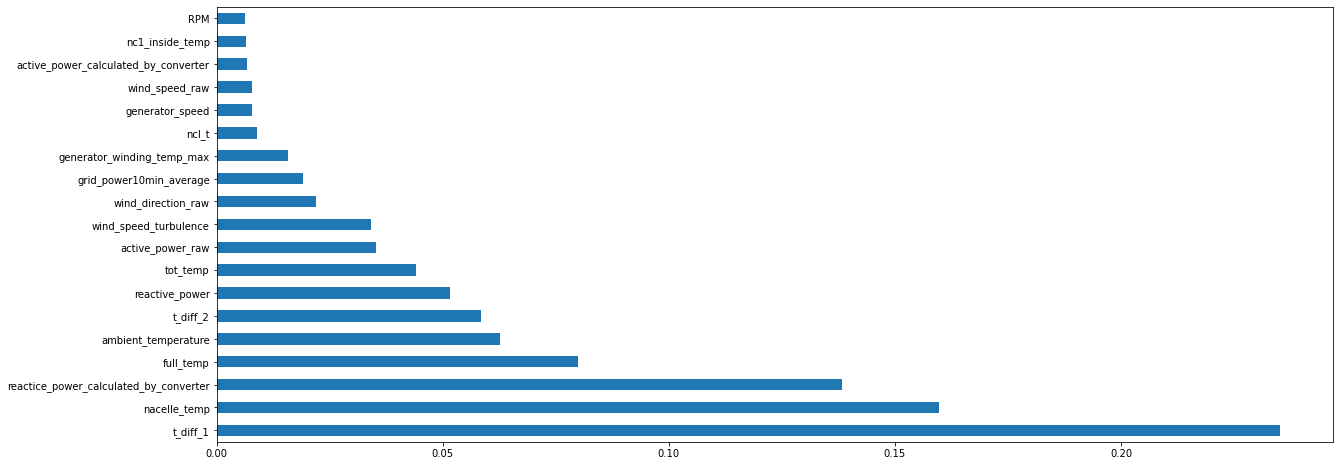

In [18]:
plt.figure(figsize = (20,8))
feat_importances = pd.Series(model.feature_importances_, index=useful_feature)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

# model pub lb 0.01173

In [34]:
#we are using xgb as the model with above parameters 
#since there is some distribution difference we are training unique model for each turbine id 
#this method gives more accurate score
#train each data with turbine id from 0 to 15 , and predict test data corresponding to each turine id
#got 0.01171 public lederboard (chance of overfitting using full data without validation )
#other approach is also given ,check its private score ,0.01201(public leaderboard)

df=train_new.copy()
tt=test_new.copy()
from sklearn.model_selection import train_test_split
scores=[]
final_test_pr={}
final_valid_pr={}
for fold in range(16):
  xtrain_new=df[df.turbine_id==fold].reset_index(drop=True)  #divding the dataset selecting subsample for training
  xtest=tt[tt.turbine_id==fold].reset_index(drop=True)       #according to each turbine_id,also filtering out testsubsample
  test_ids=xtest.id.values.tolist()                          #by turbine ,saving their id for ordering them for final 
  xtest=xtest[useful_feature]                                #submission
  #xtrain, xvalid, ytrain, yvalid = train_test_split(
    #xtrain_new[useful_feature],
    #xtrain_new['Target'],
    #test_size    = 0.1,                                          #validation part 
    #random_state = 42,
    #shuffle      = True)

  lgbm = XGBRegressor(**next_1_516,random_state=42)
  model=lgbm.fit(xtrain_new[useful_feature], xtrain_new['Target'])

  #valid_pred = model.predict(xvalid)

  #rmse=np.sqrt(mean_squared_error(yvalid,valid_pred))
  print(fold)
  #scores.append(rmse)

  test_p=model.predict(xtest)  #predicting test set
  final_test_pr.update(dict(zip(test_ids,test_p))) #combing the test datasets

#print(np.mean(scores),np.std(scores))





[17:25:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0
[17:29:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1
[17:32:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
2
[17:35:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
3
[17:38:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
4
[17:41:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
5
[17:44:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
6
[17:47:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated 

In [35]:
prdd=pd.DataFrame(final_test_pr.items(), columns=['id', 'Target'])
prdd.shape

(303202, 2)

In [36]:
prdd

,id,Target
0,15,56.509769
1,56,47.075203
2,73,48.625107
3,106,47.052086
4,110,47.532467
...,...,...
303197,303137,45.517715
303198,303163,45.966629
303199,303178,45.294395
303200,303180,45.753365


In [37]:
prdd

,id,Target
0,15,56.509769
1,56,47.075203
2,73,48.625107
3,106,47.052086
4,110,47.532467
...,...,...
303197,303137,45.517715
303198,303163,45.966629
303199,303178,45.294395
303200,303180,45.753365


In [38]:
prdd=prdd.sort_values('id')
prdd=prdd.reset_index(drop=True)
prdd

,id,Target
0,0,49.813023
1,1,41.017090
2,2,48.717163
3,3,46.244160
4,4,45.181938
...,...,...
303197,303197,51.624531
303198,303198,47.603825
303199,303199,45.743671
303200,303200,47.333363


In [39]:
ss['Target']=prdd['Target']

In [40]:
ss['Target'].describe()

count    303202.000000
mean         46.310654
std           2.385450
min          27.139116
25%          44.993684
50%          46.305012
75%          47.580339
max          64.977127
Name: Target, dtype: float64

In [25]:
ss.to_csv('full_data.csv',index=False)

# model pub lb 0.01203 + validation of the dataset no need of running

run this code for checking validation scores only

In [ ]:
df=train_new.copy()
tt=test_new.copy()
from sklearn.model_selection import train_test_split
scores=[]
final_test_pr={}
final_valid_pr={}
for fold in range(16):
  xtrain_new=df[df.turbine_id==fold].reset_index(drop=True)  #divding the dataset selecting subsample for training
  xtest=tt[tt.turbine_id==fold].reset_index(drop=True)       #according to each turbine_id,also filtering out testsubsample
  test_ids=xtest.id.values.tolist()                          #by turbine ,saving their id for ordering them for final 
  xtest=xtest[useful_feature]                                #submission
  xtrain, xvalid, ytrain, yvalid = train_test_split(
    xtrain_new[useful_feature],
    xtrain_new['Target'],
    test_size    = 0.1,                                          #validation part 
    random_state = 42,
    shuffle      = True)

  lgbm = XGBRegressor(**next_1_516,random_state=42)
  model=lgbm.fit(xtrain_new[useful_feature], xtrain_new['Target'])

  valid_pred = model.predict(xvalid)

  rmse=np.sqrt(mean_squared_error(yvalid,valid_pred))
  print(fold)
  scores.append(rmse)

  test_p=model.predict(xtest)  #predicting test set
  final_test_pr.update(dict(zip(test_ids,test_p))) #combing the test datasets

print(np.mean(scores),np.std(scores))

In [ ]:
prdd=pd.DataFrame(final_test_pr.items(), columns=['id', 'Target'])
prdd.shape